In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import random
import pandas as pd
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
from dataset import get_data
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = "../data/kaggle_data/"

In [4]:
# make dataset

def data_extract(df_dict, df, name, cols):
       for col in cols:
              df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
       return df_dict

train_data_list = []
val_data_list = []

pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'PJM_Load', 'EKPC'

df_dict = {}

df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

for df_name in df_dict:
    df = df_dict[df_name]
    train_data, val_data, scaler = get_data(df, False)
    print(df_name, len(train_data), len(val_data))
    train_data_list.append((train_data, df_name, scaler))
    val_data_list.append((val_data, df_name, scaler))

PMJ_AEP 4044 1011
PMJ_COMED 2217 555
PMJ_DAYTON 4044 1011
PMJ_DEOK 1925 482
PMJ_DOM 3874 969
PMJ_DUQ 3970 993
PMJ_FE 2096 525
PMJ_NI 1949 488
PMJ_PJME 4847 1212
PMJ_PJMW 4775 1194


In [5]:
tmp_data, t, scaler = train_data_list[0]
tmp_data = pd.DataFrame(tmp_data)
tmp_data.head()

,0
0,328544.0
1,311997.0
2,293450.0
3,343417.0
4,346553.0


In [6]:
tmp_diff1 = tmp_data.diff().dropna()
tmp_diff1.head()

,0
1,-16547.0
2,-18547.0
3,49967.0
4,3136.0
5,-358.0


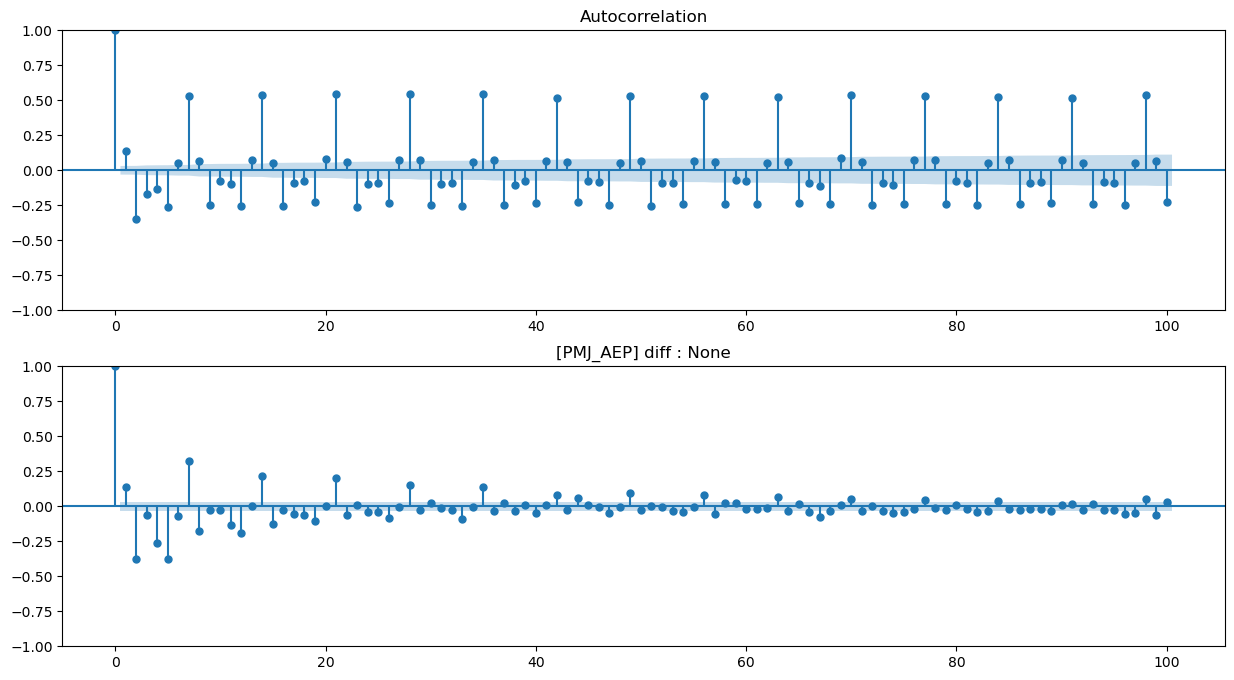

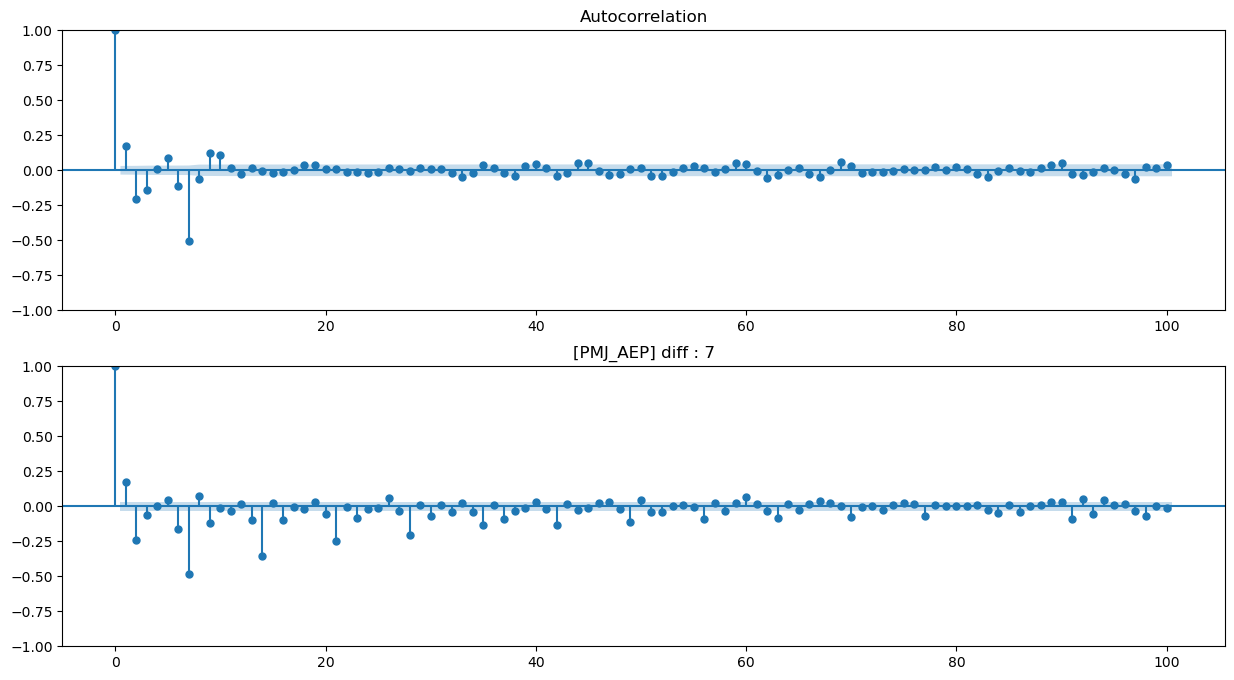

In [7]:
from util import plot_ac
diff = [7]

plot_ac(tmp_diff1, t, diff, data=False, acf=True, pacf=True, lags=100)

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p, d, q)(P, D, Q, S)

orders = [(0, 7, 2)]
bset_AIC = float('inf')
for order in orders:
    model = ARIMA(tmp_diff1, order=order, seasonal_order=(0, 2, 2, 7))
    model_fit = model.fit()

    print(model_fit.summary())

    if bset_AIC > model_fit.aic:
        best_model = model_fit
        best_AIC = model_fit.aic

forecast = best_model.forecast(steps=10)

c:\Users\qja19\AppData\Local\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\qja19\AppData\Local\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\qja19\AppData\Local\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                               0   No. Observations:                 4043
Model:             ARIMA(0, 7, 2)x(0, 2, 2, 7)   Log Likelihood              -60699.072
Date:                         Wed, 15 May 2024   AIC                         121408.143
Time:                                 21:36:23   BIC                         121439.641
Sample:                                      0   HQIC                        121419.305
                                        - 4043                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9544      0.375     -5.214      0.000      -2.689      -1.220
ma.L2          0.9862      0.393      2.507      0.012     

c:\Users\qja19\AppData\Local\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [7]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(tmp_data,
                              max_p=5,
                              max_q=5,
                              d=7,
                              seasonal=True,
                              max_P=2,
                              max_Q=2,
                              m=7,
                              max_order=5,
                              with_intercept='auto',
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False,
                              n_jobs=-1)

auto_arima_model.summary()

forecast = auto_arima_model.predict(n_periods=100)


Best model:  ARIMA(5,7,0)(0,0,0)[7]          
Total fit time: 210.865 seconds


4044    2.843116e+05
4045    6.498665e+04
4046   -5.844729e+05
4047   -2.049233e+06
4048   -4.860212e+06
            ...     
4139   -7.844537e+12
4140   -8.320684e+12
4141   -8.820667e+12
4142   -9.345430e+12
4143   -9.895947e+12
Length: 100, dtype: float64


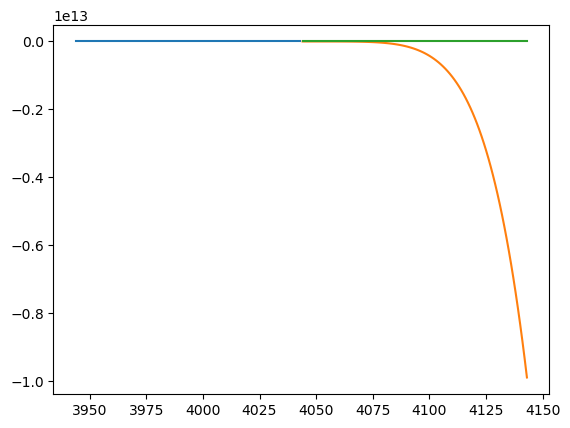

In [8]:
import matplotlib.pyplot as plt

print(forecast)
plt.plot(tmp_data[-100:])
plt.plot(forecast, label='forecast')
plt.plot(list(forecast.index), val_data_list[0][0][:len(forecast)])